# Mesh2d refinement based on Gebco gridded samples

This is a brief introduction to the process of mesh refinement using gridded samples from Gebco global dataset. 

It is also an example of 
1. Generating a mesh of defined extension
2. Saving the generated mesh to UGrid file
3. Reading bathymetric data form a large NetDFC file
4. Performing mesh refinement based on uniformly spaced gridded bathymetric data (fast), non-uniformly spaced bathymetric data (slow). 

Import necessary libraries, close all figures

In [1]:
import meshkernel
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')

# 1. Generating a mesh of defined extension

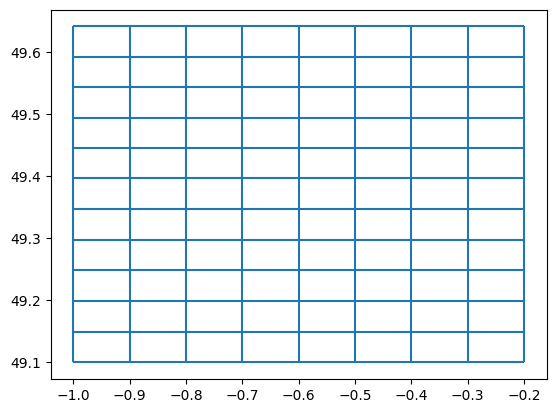

In [2]:
#general settings
lon_min,lon_max = -1,-0.2
lat_min,lat_max = 49.1,49.6
lon_res,lat_res = 0.1,0.1
figsize = (10,4)
crs = 'EPSG:4326'

"""
Make a regular (potentially rotated) rectilinear grid. First generate a curvilinear grid than convert the curvilinear grid into unstructured grid. The steps are the following:
- curvilinear_compute_uniform_on_extension, see the following notebook: https://github.com/Deltares/MeshKernelPy/blob/AddCurvilinearGridSupport/docs/examples/04_curvilineargrid_basics.ipynb
- curvilinear_convert_to_mesh2d: https://github.com/Deltares/MeshKernelPy/blob/118cb4953c4e95d5b18ed283bb37f391134b2bb2/meshkernel/meshkernel.py#L1399 
"""

# Create an instance of MakeGridParameters and set the values
make_grid_parameters = meshkernel.MakeGridParameters()
make_grid_parameters.origin_x = lon_min
make_grid_parameters.origin_y = lat_min
make_grid_parameters.upper_right_x = lon_max
make_grid_parameters.upper_right_y = lat_max
make_grid_parameters.block_size_x = lon_res
make_grid_parameters.block_size_y = lat_res


mk2 = meshkernel.MeshKernel(projection=meshkernel.ProjectionType.SPHERICAL)
mk2.curvilinear_compute_rectangular_grid_on_extension(make_grid_parameters)
mk2.curvilinear_convert_to_mesh2d() #convert to ugrid/mesh2d

mesh2d = mk2.mesh2d_get()
fig, ax = plt.subplots()
mesh2d.plot_edges(ax)

# 2. Saving the generated mesh to UGrid file

To save the generated mesh to a UGrid file, you can use the following code snippet. Please note that in order to execute the code below, the UGrid Python package needs to be installed.

In [3]:
ugrid_installed = False
if ugrid_installed:

    from ugrid import UGrid, UGridMesh2D

    mesh2d_ugrid = UGrid.from_meshkernel_mesh2d_to_ugrid_mesh2d(mesh2d=mesh2d, name="mesh2d", is_spherical=True)

    attribute_dict = {
            "name": "Unknown projected",
            "epsg": np.array([4326], dtype=int),
            "grid_mapping_name": "Unknown projected",
            "longitude_of_prime_meridian": np.array([0.0], dtype=float),
            "semi_major_axis": np.array([6378137.0], dtype=float),
            "semi_minor_axis": np.array([6356752.314245], dtype=float),
            "inverse_flattening": np.array([6356752.314245], dtype=float),
            "EPSG_code": "EPSG:4326",
            "value": "value is equal to EPSG code"}

    with UGrid("./gebco_mesh2d_net.nc", "w+") as ug:
        # 1. Define a new mesh2d
        topology_id = ug.mesh2d_define(mesh2d_ugrid)
        # 3. Put a new mesh2d
        ug.mesh2d_put(topology_id, mesh2d_ugrid)
        # 3. Add crs to file
        ug.variable_int_with_attributes_define("wgs84", attribute_dict)
        # 4. Add conventions (global attributes)
        conventions = {
            "institution": "Deltares",
            "references": "Unknown",
            "source": "Unknown Unknown. Model: Unknown",
            "history": "Created on 2017-11-27T18:05:09+0100, Unknown",
            "Conventions": "CF-1.6 UGRID-1.0/Deltares-0.8"}
        ug.attribute_global_define(conventions)

# 3. Reading bathymetric data form a large NetDFC file

Bathymetric data can be read from a large dataset using the xarray package, which allows you to load only a selected portion of the data. When the longitude and latitude arrays are assumed not uniformly spaced, bilinear interpolation is slower

In [4]:
#select and plot bathy
uniform_grid_spacing = True
if not uniform_grid_spacing:
    
    import xarray as xr
    
    file_nc_bathy = r'p:\metocean-data\open\GEBCO\2021\GEBCO_2021.nc'
    data_bathy = xr.open_dataset(file_nc_bathy)
    data_bathy_sel = data_bathy.sel(lon=slice(lon_min-1/4,lon_max+1/4),lat=slice(lat_min-1/4,lat_max+1/4))
    
    lon_np = data_bathy_sel.lon.to_numpy().flatten().astype('float') 
    lat_np = data_bathy_sel.lat.to_numpy().flatten().astype('float') 
    values_np = data_bathy_sel.elevation.to_numpy().flatten().astype('float') 

Otherwise, read from ascii, assuming uniform spacing

In [5]:
def read_asc_file(file_path):
    header = {}
    data = []

    with open(file_path, 'r') as file:
        for _ in range(6):
            line = file.readline().strip().split()
            header[line[0]] = float(line[1])
            
        for line in file:
            data_row = [float(value) for value in line.strip().split()]
            data.insert(0, data_row)
            
        data = np.array(data).flatten().astype(np.double)
        
    return header, data

header, values_np = read_asc_file('./data_examples/gebco.asc')

num_x= int(header['ncols'])
num_y= int(header['nrows'])
x_origin=header['xllcenter']
y_origin=header['yllcenter']

# 4. Performing mesh refinement based on gridded data

In [6]:
gridded_samples = meshkernel.GriddedSamples(num_x=num_x,
                                            num_y= num_y,
                                            x_origin=x_origin,
                                            y_origin=y_origin,
                                            cell_size=0.0041666666666,
                                            values=values_np)

Another option is to generate gridded samples from an array of x and y coordinates, not uniformly spaced

In [7]:
if not uniform_grid_spacing:
    gridded_samples = meshkernel.GriddedSamples(x_coordinates = lon_np,
                                                y_coordinates = lat_np,
                                                num_x = len(lon_np),
                                                num_y = len(lat_np),
                                                values=values_np)

Define the mesh refinement parameters 

In [8]:
mesh_refinement_parameters = meshkernel.MeshRefinementParameters(refine_intersected=False,
                                                                 use_mass_center_when_refining=False,
                                                                 min_edge_size=500, 
                                                                 refinement_type=meshkernel.RefinementType(1),
                                                                 connect_hanging_nodes=True, 
                                                                 account_for_samples_outside_face=False, 
                                                                 max_refinement_iterations=3,
                                                                 smoothing_iterations=5,
                                                                 max_courant_time=120.0,
                                                                 directional_refinement=0)

Perform the refinement (Bilinear interpolation will be used)

In [9]:
mk2.mesh2d_refine_based_on_gridded_samples(gridded_samples=gridded_samples,
                                           mesh_refinement_params=mesh_refinement_parameters,
                                           use_nodal_refinement=True)

Plot the refined mesh

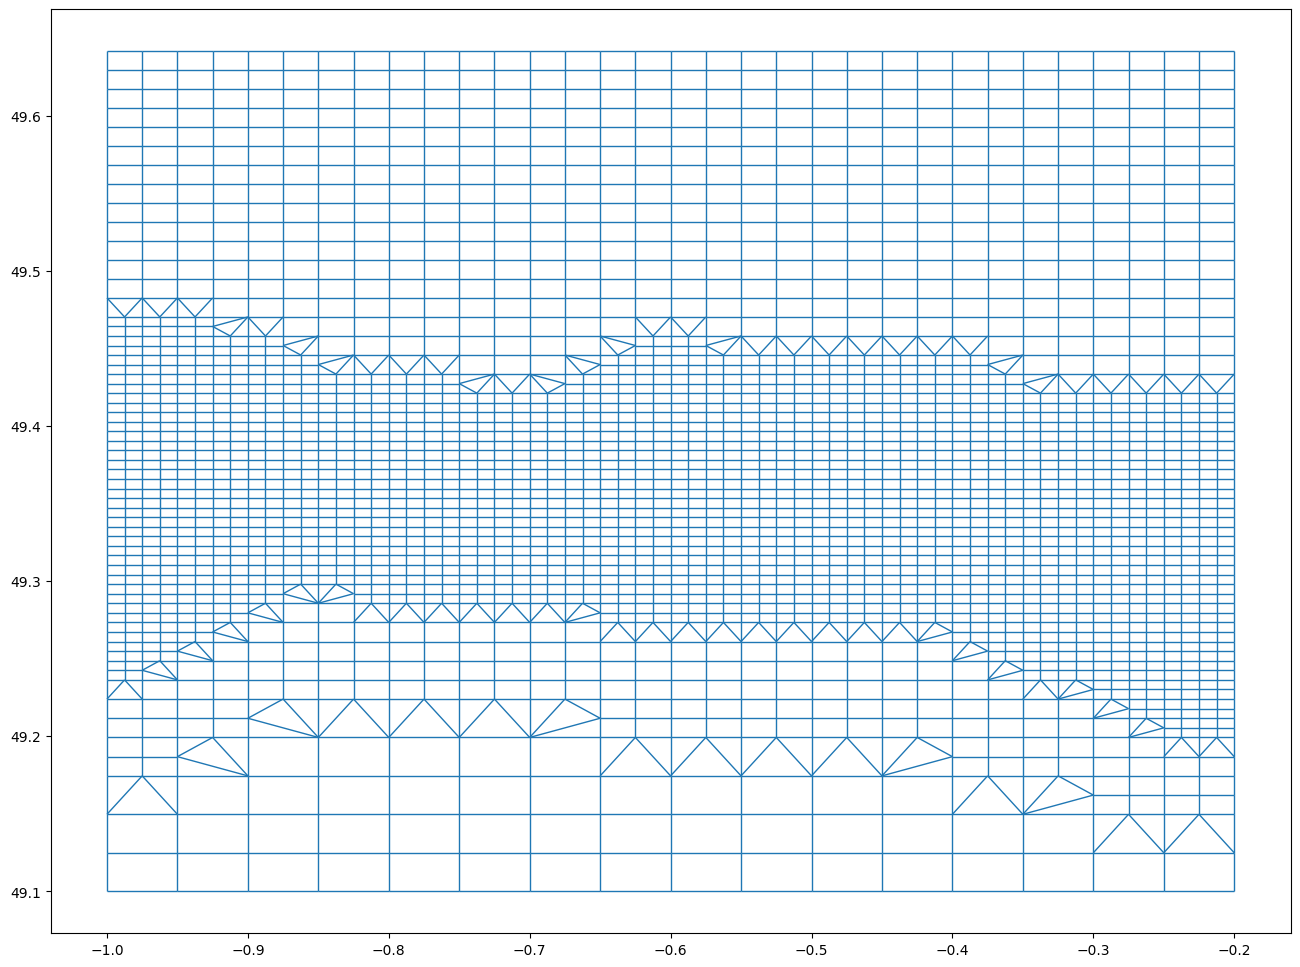

In [10]:
#zoomed in plot to focus on patchy coastlines
fig1 = plt.figure(figsize=(16, 12))
ax1 = fig1.add_subplot(111)

mesh2d_grid2 = mk2.mesh2d_get()
mesh2d_grid2.plot_edges(ax1,linewidth=1)